# Approach 1: difference between frames
Based on code created by Rune, available on <br>
https://www.learnpythonwithrune.org/opencv-counting-cars-a-simple-approach/

In [2]:
import cv2
import imutils
import ipywidgets as widgets
import threading
import numpy as np
import matplotlib.pyplot as plt

# Play video

In [3]:
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('videos/13_de_maio.mp4')

# Check if camera opened successfully
if (cap.isOpened()== False): 
      print("Error opening video stream or file")

# # Read until video is completed
frames = []
while(cap.isOpened()):
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        frames.append(frame)
            
        # Display the resulting frame
        cv2.imshow('Frame',frame)
        
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

  # Break the loop
    else: 
        break

# When everything done, release the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()

# Difference between frames

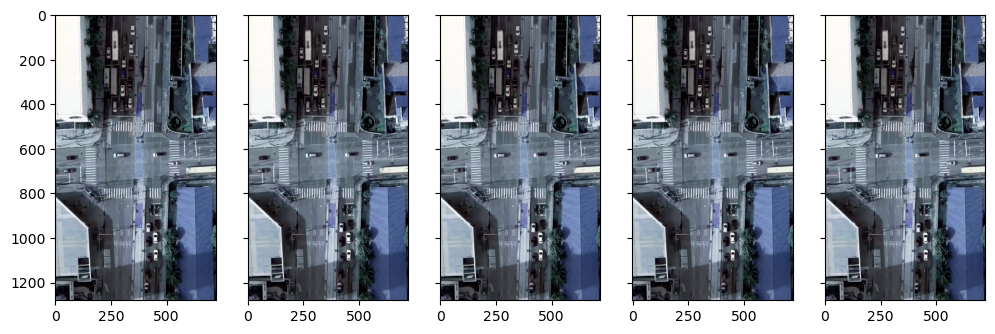

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(12, 4), dpi = 100, sharey=True)
for i in range(5):
    ax[i].imshow(frames[i])


## Grayscale and gaussian blur

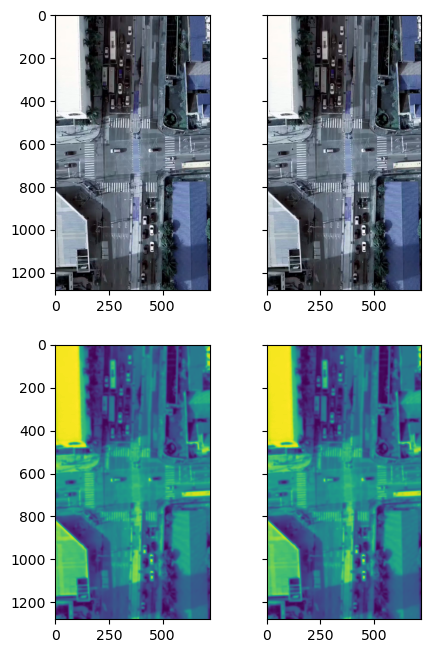

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(5, 8), dpi = 100, sharey=True)
frame = frames[1]
last_frame = frames[0]
# initial
ax[0,0].imshow(frame)
ax[0,1].imshow(last_frame)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# We blur it to minimize reaction to small details
gray = cv2.GaussianBlur(gray, (21, 21), 0)

last_gray = cv2.cvtColor(last_frame, cv2.COLOR_BGR2GRAY)
# We blur it to minimize reaction to small details
last_gray = cv2.GaussianBlur(last_gray, (21, 21), 0)

ax[1,0].imshow(gray)
ax[1,1].imshow(last_gray)

## Thresholding the difference between frames

box 0 area: 46.5
box 1 area: 61.5
box 2 area: 71.0
box 3 area: 185.0
box 4 area: 71.5
box 5 area: 389.5
box 6 area: 24.0
box 7 area: 157.0
box 8 area: 160.0
box 9 area: 464.0
box 10 area: 472.0


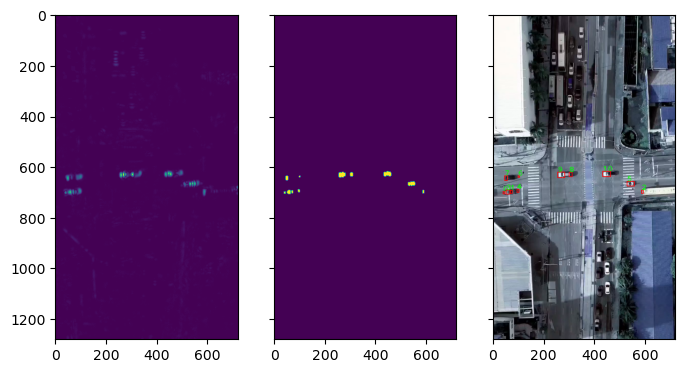

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(8, 12), dpi = 100, sharey=True)

# Get the difference from last_frame
delta_frame = cv2.absdiff(last_gray, gray)
ax[0].imshow(delta_frame)

# Have some threshold on what is enough movement
thresh = cv2.threshold(delta_frame, 25, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.dilate(thresh, None, iterations=2)
ax[1].imshow(thresh)

# Returns a list of objects
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Converts it
contours = imutils.grab_contours(contours)
# Loops over all objects found
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    print('box ' + str(i) + ' area: ' + str(area))
    # Get's a bounding box and puts it on the frame
    (x, y, w, h) = cv2.boundingRect(contour)
    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
    if area > 100:
        text = str(i) + ' vehicle'
    else:
        text = str(i) + ' pedestrian'
    cv2.putText(frame, str(i), (x, y), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    
ax[2].imshow(frame)

# Counting objects that pass through boxes

In [7]:
class Box:
    def __init__(self, start_point, width_height):
        self.start_point = start_point
        self.end_point = (start_point[0] + width_height[0], start_point[1] + width_height[1])
        self.counter = 0
        self.frame_countdown = 0
    def overlap(self, start_point, end_point):
        if self.start_point[0] >= end_point[0] or self.end_point[0] <= start_point[0] or \
                self.start_point[1] >= end_point[1] or self.end_point[1] <= start_point[1]:
            return False
        else:
            return True

In [8]:
frame.shape

(1280, 720, 3)

In [9]:
cap = cv2.VideoCapture('videos/13_de_maio.mp4')

# We will keep the last frame in order to see if there has been any movement
last_frame = None
# To build a text string with counting status
text = ""
# The boxes we want to count moving objects in
boxes = []
# horizontal
boxes.append(Box((0, 0), (720, 10)))
# vertical
boxes.append(Box((0, 0), (10, 1280)))

pedestrians = 0
vehicles = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # Processing of frames are done in gray    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # We blur it to minimize reaction to small details
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    # Need to check if we have a lasqt_frame, if not get it
    if last_frame is None or last_frame.shape != gray.shape:
        last_frame = gray
        continue
    # Get the difference from last_frame
    delta_frame = cv2.absdiff(last_frame, gray)
    last_frame = gray
    # Have some threshold on what is enough movement
    thresh = cv2.threshold(delta_frame, 25, 255, cv2.THRESH_BINARY)[1]
    # This dilates with two iterations
    thresh = cv2.dilate(thresh, None, iterations=2)
    # Returns a list of objects
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Converts it
    contours = imutils.grab_contours(contours)
    # Loops over all objects found
    for contour in contours:
        # Skip if contour is small (can be adjusted)
        if cv2.contourArea(contour) < 20:
            continue
        if cv2.contourArea(contour) > 100:
            object_type = 'car'
        else:
            object_type = 'pedestrian'
            
        # Get's a bounding box and puts it on the frame
        (x, y, w, h) = cv2.boundingRect(contour)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # The text string we will build up
        text = "Cars:"
        # Go through all the boxes
        for box in boxes:
            box.frame_countdown -= 1
            if box.overlap((x, y), (x + w, y + h)):
                if box.frame_countdown <= 0:
                    if object_type == 'pedestrian':
                        pedestrians += 1
                    else:
                        vehicles += 1
                        
                    box.counter += 1
                # The number might be adjusted, it is just set based on my settings
                box.frame_countdown = 20
            text += " (" + str(box.counter) + " ," + str(box.frame_countdown) + ")"
    # Set the text string we build up
    cv2.putText(frame, text, (10, 20), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    # Let's also insert the boxes
    for box in boxes:
        cv2.rectangle(frame, box.start_point, box.end_point, (255, 255, 255), 2)
    # Let's show the frame in our window
    cv2.imshow("Car counter", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [13]:
pedestrians_count = pedestrians/2
vehicles_count = vehicles/2
print('pedestrians',int(pedestrians_count))
print('vehicles',int(vehicles_count))

pedestrians 179
vehicles 274


# Recognize each object